In [3]:
%matplotlib inline
import os
import sys

sys.path.append("/home/pkarpov/Sapsan")

from sapsan.lib.backends import MLflowBackend, FakeBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate
from sapsan.utils.plot import cdf_plot, pdf_plot, line_plot


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import numpy as np

def plot_params():
    params = {'font.size': 14, 'legend.fontsize': 14, 
              'axes.labelsize': 20, 'axes.titlesize':24,
              'xtick.labelsize': 17,'ytick.labelsize': 17,
              'axes.linewidth': 1, 'patch.linewidth': 3, 'lines.linewidth': 3,
              'xtick.major.width': 1.5,'ytick.major.width': 1.5,
              'xtick.minor.width': 1.25,'ytick.minor.width': 1.25,
              'xtick.major.size': 7,'ytick.major.size': 7,
              'xtick.minor.size': 4,'ytick.minor.size': 4,
              'xtick.direction': 'in','ytick.direction': 'in',              
              'axes.formatter.limits' : [-7, 7], 
              'axes.grid':True, 'grid.linestyle': ':', 'grid.color':'#999999',
              'text.usetex': False}              
    return params

class ComputeRoutines:
    #
    # Routines to calculate PNS radius and shock position
    #
    def __init__(self, x, rho, v, vsound=None):
        self.x          = x
        self.rho        = rho
        self.v          = v  
        self.vsound     = vsound      
        self.shock_ind  = 0
        self.shock_x    = 0
        self.pns_ind    = 0
        self.pns_x      = 0        
        
    def shock_radius(self):        

        if self.vsound != None:                        
            mach = abs(self.v/self.vsound)
            
            for i in range(np.argmin(self.v),-1,-1):            
                if mach[i] < 1:
                    self.shock_ind = i
                    self.shock_x   = self.x[self.shock_ind]
                    break
        else:
            self.shock_ind = np.argmin(self.v)
            self.shock_x   = self.x[self.shock_ind]
    
        #print('shock position: %.2e'%self.shock_x, self.shock_ind)
        return self.shock_ind, self.shock_x
        
    def pns_radius(self, rho_threshold = 2e11):      
          
        for i in range(len(self.rho)):            
            if self.rho[i] > rho_threshold:
                self.pns_ind = i
                self.pns_x   = self.x[i]
                
        return self.pns_ind, self.pns_x    

def get_numfiles(base, base_file):
    numfiles = len([filename for filename in os.listdir(f'{base}') if base_file in filename])
    return numfiles

In [5]:
def process_var(var, v, new_r, pns_i,shock_i):
    f = interpolate.interp1d(np.arange(len(v))[pns_i:shock_i+1], var[pns_i:shock_i+1])
    return f(new_r)

def interp_var(x, y, mlin_grid_size, fudge_pns=0, fudge_shock=0):
    mlin_x = np.zeros((x.shape[0], x.shape[1], mlin_grid_size))
    if y.any()!=None: mlin_y = np.zeros((y.shape[0], y.shape[1], mlin_grid_size))
    for i in range(x.shape[0]):
        v   = x[i,0,:]
        rho = x[i,1,:]
        
        rt = ComputeRoutines(range(len(v)), rho=rho, v=v)
        shock_i, shock_x = rt.shock_radius()
        pns_i,   pns_x   = rt.pns_radius(rho_threshold = 1e13)   
        
        pns_i   += fudge_pns
        shock_i += fudge_shock
        
        # Should I add 1 to track all the way down to minv?
        shock_i +=1
        
        new_r = np.linspace(pns_i,shock_i,mlin_grid_size)

        if y.any()!=None: mlin_y[i,0] = process_var(y[i,0], v, new_r, pns_i,shock_i)        
        
        for j in range(x.shape[1]): 
            mlin_x[i,j] = process_var(x[i,j], v, new_r, pns_i,shock_i)
            
        print('Convective region from/to: ',pns_i, shock_i)

    if y.any()!=None: return mlin_x, mlin_y, pns_i,shock_i
    else: return mlin_x, pns_i,shock_i

In [6]:
# Resolution: 678x128x256 (r x theta x phi): r, pi and 2pi respectively
# outter radius is 2e4 km (2e9 cm)

#comp0: Ye
#eos0: gas pressure
#eos1: sound speed
#eos2: Temperature
#eos3: entropy
#eos4: gamma_1
#The rad variables of relevance are Erad0, Erad1, Erad2 (0, 1, 2 corresponding to electron neutrinos, electron anti-neutrinos, and heavy neutrinos) energy densitivies, and analgously for Frad0,1,2.

#['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 
#'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 
#'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 
#'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 
#'velocity0', 'velocity1', 'velocity2']

#path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"

smass = 's19.0'
base_path = '/home/pkarpov/scratch/adam'
dataset = f'{smass}.swbj15.horo.3d/'
base = f'{base_path}/{dataset}'

path = base+"dump_{checkpoint:05d}.h5"

# velocity, rho, P_gas, Vsound, T, entropy
features_label = ['u1','rho','eos0','eos2','eos1','Pturb_s2']#,'eos1']#,'eos3']
target_label = ['Pturb_s2']
#target_label = ['u1']
target = ['dummy']

#Dimensionality of your data in format (D,H,W)
INPUT_SIZE = [678]

#Reduce dimensionality to the following in format (D,H,W)
#SAMPLE_TO = (16,16,16)

#Sampler to use for reduction
#sampler = EquidistantSampling(SAMPLE_TO)

23 192
24 198
33 199
 Checkpoints:    199
 For Training:   25
 For Validation: 9
 Checkpoints:    [200]

Features:  ['None']
Fetures_label: ['Z']
Loading 'Z' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/grid.h5'
----------
Features:  ['None']
Fetures_label: ['Time']
Loading 'Time' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos0', 'eos2', 'eos1', 'Pturb_s2']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Loading 'eos2' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s19.0.swbj15.horo.3d/dump_00200.h5'
----------
Loading 'Pturb_s2' from file '/home/p

/home/pkarpov/Sapsan/sapsan/utils/plot.py:209: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize, dpi=dpi)


(46.0, 226.0)

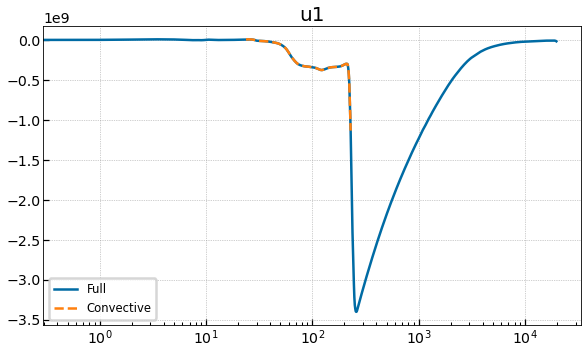

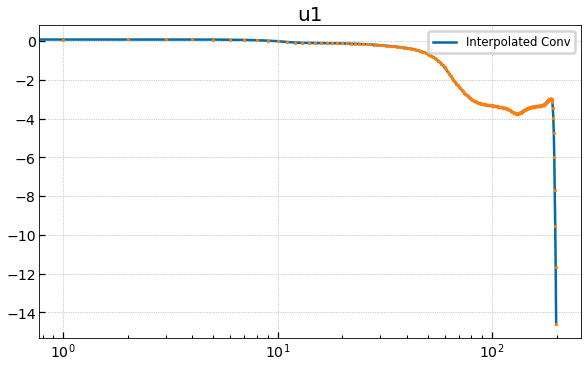

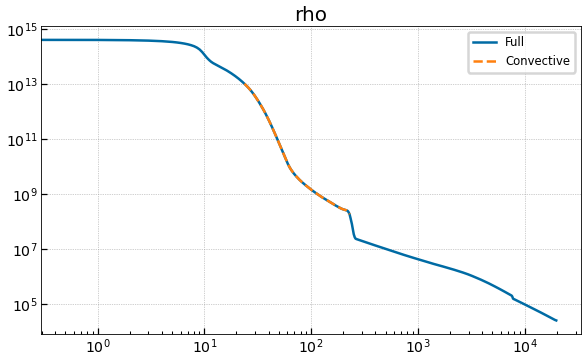

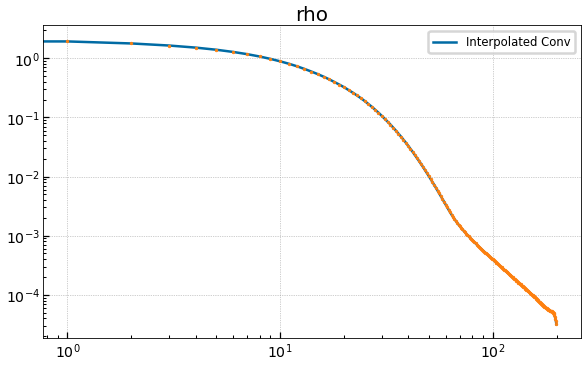

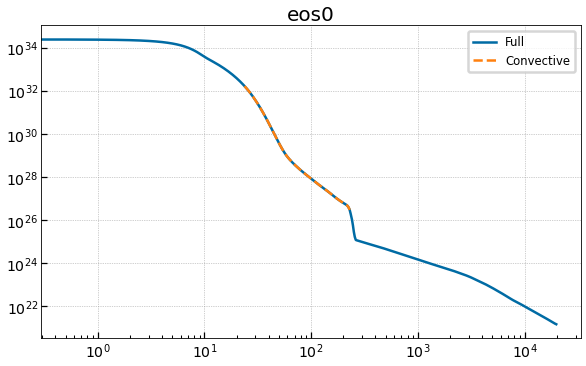

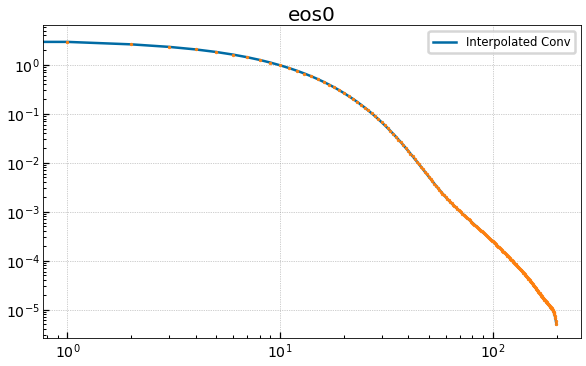

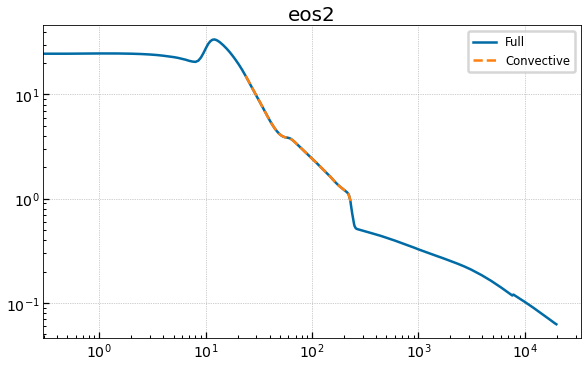

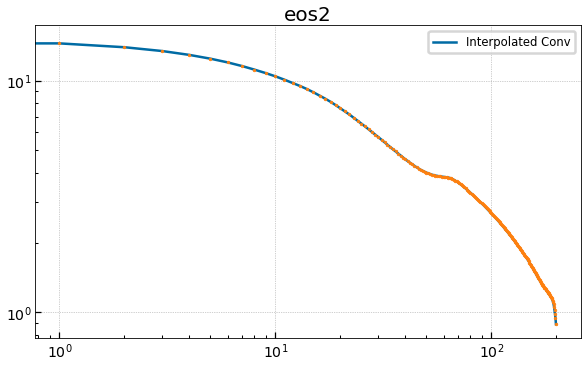

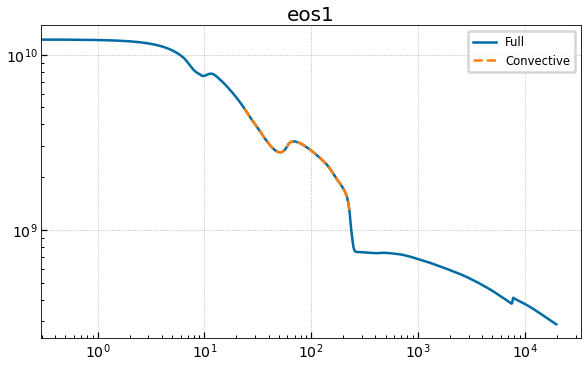

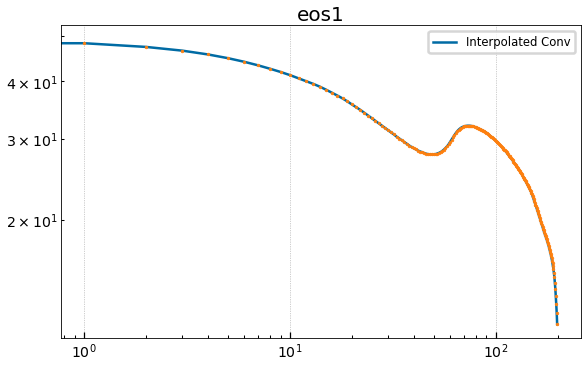

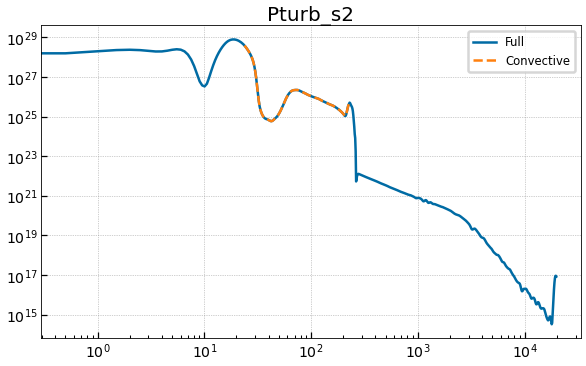

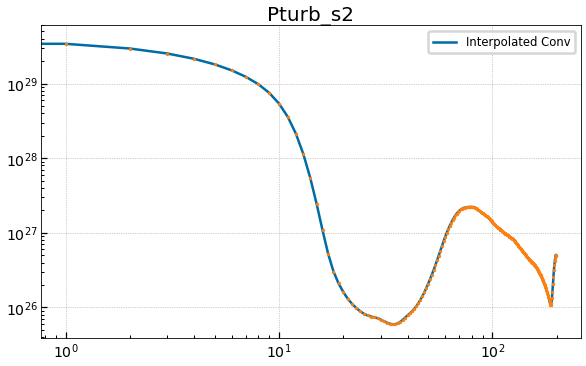

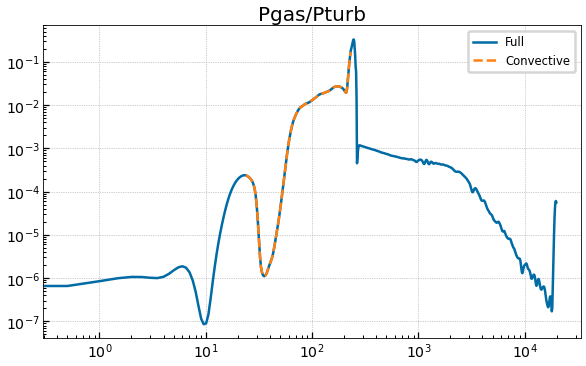

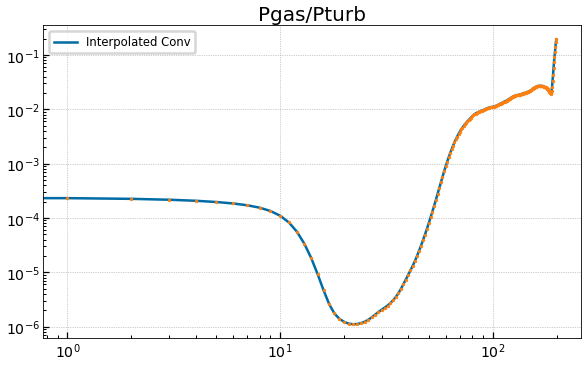

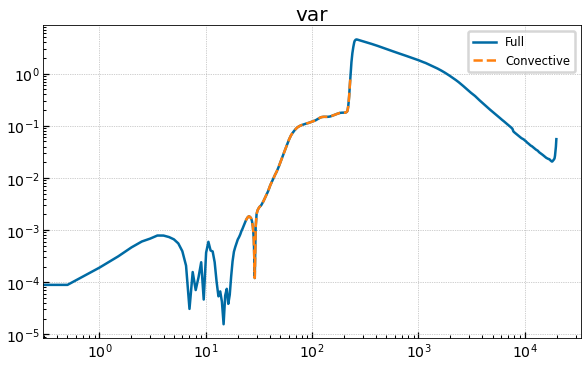

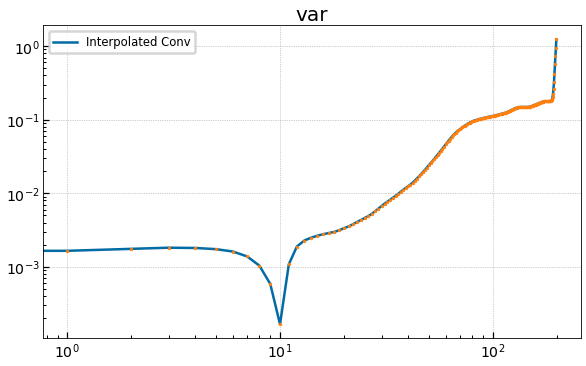

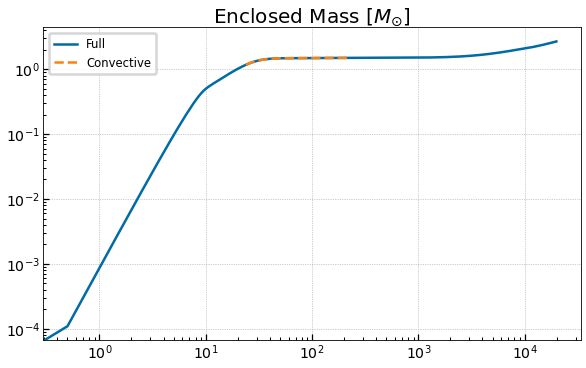

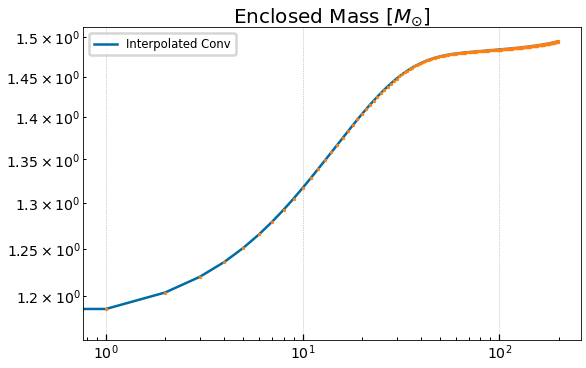

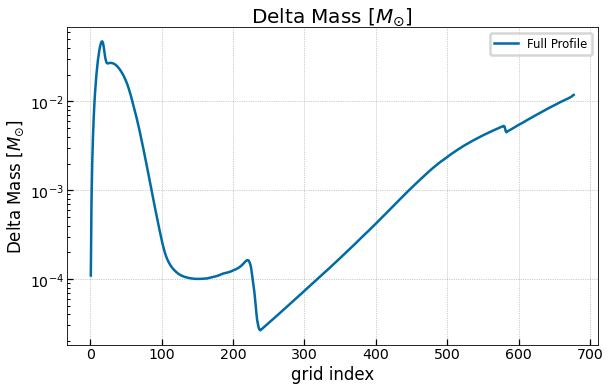

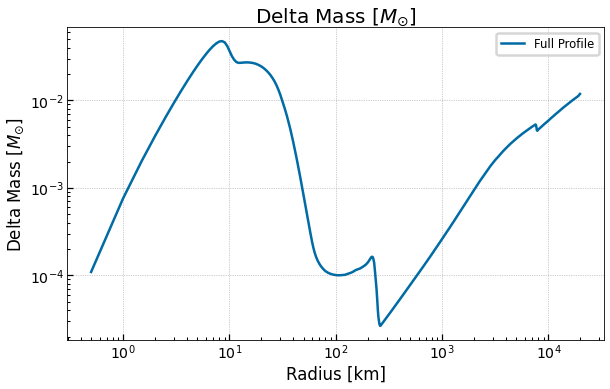

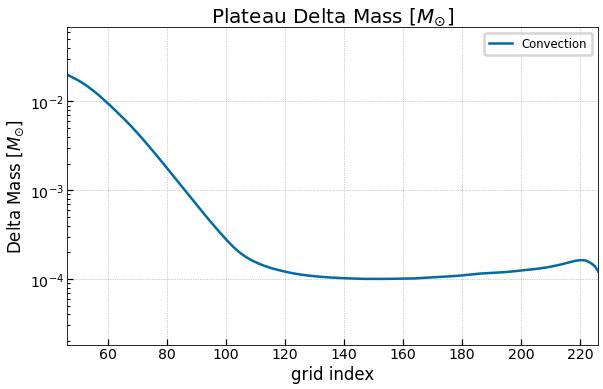

In [7]:
from scipy import interpolate
import numpy as np
# checkpoints = [30,40,50,60,70,80,90,100,110,
#                120,130,140,150,160,170,180,200,210,
#                115,125,135,145,155,165,175,
#                35,65,117,127,137,147]#,180,
#                #187,200,210]#,220,230,240,250,260,
#                #270,280,290,300]
# #checkpoints = [180]

# Assign training checkpoints (15% of the total number)
numfiles = get_numfiles(base, 'dump_')
start = 30
interval          = int((numfiles-start)/(numfiles*0.10))
train_files       = int((numfiles-start)/interval)
train_files_early = int(train_files*1/3)
train_files_late  = int(train_files*2/3)

interval_early    = int(np.rint(((numfiles-start)/2)/train_files_early))
interval_late     = int(np.rint(((numfiles-start)/2)/train_files_late))
checkpoints_early = [i for i in range(start, int((numfiles-start)/2),    interval_early)]
checkpoints_late  = [i for i in range(int((numfiles-start)/2), numfiles, interval_late )]
checkpoints       = checkpoints_early + checkpoints_late

# 30% of the training dataset are used for validation 
valid = int(len(checkpoints)*0.3)
checkpoints_valid = [checkpoints[i]+1 for i in range(0,len(checkpoints),int(len(checkpoints)/valid))]
checkpoints += checkpoints_valid

# ----- Shift over missing files -----
files = [filename[5:10] for filename in os.listdir(f'{base}') if 'dump_' in filename]
files = [int(i) for i in files]
for i in range(len(files)-1):
    if files[i+1]-files[i] != 1: gap_file = files[i+1]

count = 0
for i,ch in enumerate(checkpoints):
    if ch not in files:
        print(i,ch)
        add = gap_file - checkpoints[i] + count
        checkpoints[i] += add
        count += 2

checkpoints = [200]
        
print(f' Checkpoints:    {numfiles}\n',
       f'For Training:   {len(checkpoints_early + checkpoints_late)}\n',
       f'For Validation: {len(checkpoints_valid)}\n',
       f'Checkpoints:    {checkpoints}\n')        

# ----- Load the Data -----

grid = HDF5Dataset(path= base+'grid.h5',
                          features_label=['Z'],
                          checkpoints=[0],
                          input_size=INPUT_SIZE)
r = grid.load_numpy().flatten()[:-1]

data_loader = HDF5Dataset(path=path,                         
                          features_label=['Time'],                          
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,                          
                          shuffle = False,
                          train_fraction = len(checkpoints)-len(checkpoints_valid))
time = data_loader.load_numpy()[0,0,0]

#Load the data
data_loader = HDF5Dataset(path=path,
                          target=target,
                          features_label=features_label,
                          target_label=target_label,
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,
                          #sampler=sampler,
                          shuffle = False,
                          train_fraction = len(checkpoints)-len(checkpoints_valid))

x, y = data_loader.load_numpy()
mlin_grid_size = 200

#mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)

units = {'u1'  : 1e-8,
         'rho' : 2e-13,#2e-6,
         'eos0': 2e-32,
         'eos1': 1e-8,
         'eos2': 1,
         'eos3': 1,
         target_label[0]:1e1
         }

#mlin_x = np.delete(mlin_x, 1, axis=1)

v      = x[0,0]
rho    = x[0,1]
P      = x[0,2]
T      = x[0,3]
vsound = x[0,4]
pturb  = x[0,5]
mach   = abs(v/vsound)
prel   = pturb/P

udist   = 1e5
Msol    = 1.989e33
encm    = np.zeros(v.shape)
dm      = np.zeros(v.shape)
dm[0]   = rho[0]*4/3*np.pi*(udist*r[0])**3/Msol
encm[0] = dm[0]

for i in range(1,len(v)):
    dm[i]   = 4/3*np.pi*rho[i]*udist**3*(r[i]**3-r[i-1]**3)/Msol
    encm[i] = encm[i-1] + dm[i]

code_vals = np.array([[v,rho,P,T,vsound,pturb,prel,mach,encm]])
print('shapes', code_vals.shape)

y = np.array(None)
mlin_x, pns_i, shock_i = interp_var(code_vals, y, mlin_grid_size,fudge_shock=-12)#, fudge_pns=-10,fudge_shock=0)

for i in range(mlin_x.shape[1]):
    try: 
        mlin_x[:,i] *= units[features_label[i]]
        print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')
    except: 
        mlin_x[:,i] *=1
        print(f'var min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')

index_full = r#range(len(v))
index_mlin = range(mlin_grid_size)

for i, val in enumerate(code_vals[0]):
    plot_type='plot'
    try: 
        title = features_label[i]
        if 'turb' in features_label[i]: plot_type='semilogy'
    except: title = 'var'    
    
    if i==0: plot_type='semilogx'#'plot'
    else: plot_type = 'loglog'#'semilogy'
    
    if i==6:
        title     = 'Pgas/Pturb'    
    elif i==8:
        title     = r'Enclosed Mass [$M_{\odot}$]'   
        #dm = [val[j+1]-val[j] for j in range(len(val[pns_i:shock_i])-1)]
        # for j in range(len(val[pns_i:shock_i])-1): print(val[j+1]-val[j])
        
    ax = line_plot([[index_full,val],
                    [index_full[pns_i:shock_i], val[pns_i:shock_i]] 
                    ],
                    figsize   = (10,6),
                    label     = ['Full','Convective'],
                    linestyle = ['-', '--'],
                    plot_type = plot_type)
    ax.set_title(title)

    ax = line_plot([[index_mlin,mlin_x[0,i,:]]],
                    label     = ['Interpolated Conv'],
                    figsize   = (10,6),
                    plot_type = plot_type)
    ax.plot(index_mlin,mlin_x[0,i,:], linewidth=0, marker='.')
    ax.set_title(title)
    
ax = line_plot([[range(1,len(dm)),dm[1:]]],
                label     = ['Full Profile'],
                figsize   = (10,6),
                plot_type = 'semilogy')
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel('grid index')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

r_fornax  = r
dm_fornax = dm
ax = line_plot([[r[1:],dm[1:]]],
                label     = ['Full Profile'],
                figsize   = (10,6),
                plot_type = 'loglog')
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel('Radius [km]')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

#ax = line_plot([[range(shock_i-pns_i),dm[pns_i:shock_i]]],
ax = line_plot([[range(1,len(dm)),dm[1:]]],
                label     = ['Convection'],
                figsize   = (10,6),
                plot_type = 'semilogy')
ax.set_title(r'Plateau Delta Mass [$M_{\odot}$]')
ax.set_xlabel('grid index')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')
ax.set_xlim(pns_i,shock_i)

 Cell  M_enclosed [M_sol]  Radius [cm]  Rho [g/cm^3]  Velocity [cm/s]  Ye  Pressure [g/cm/s^2]  Temperature [K]  Sound [cm/s]  Entropy [kb/baryon]

codу vals (1, 7, 2005)
Convective region from/to:  235 1053
u1 min: -1.365e+00, max: 1.795e+00
rho min: 5.831e-02, max: 1.672e+01
eos0 min: 1.921e-02, max: 1.610e+01
eos2 min: 2.281e+01, max: 1.224e+02
eos1 min: 1.901e+01, max: 4.141e+01
Pturb_s2 min: 0.000e+00, max: 0.000e+00
var min: 1.295e-04, max: 9.267e-02


(235.0, 1053.0)

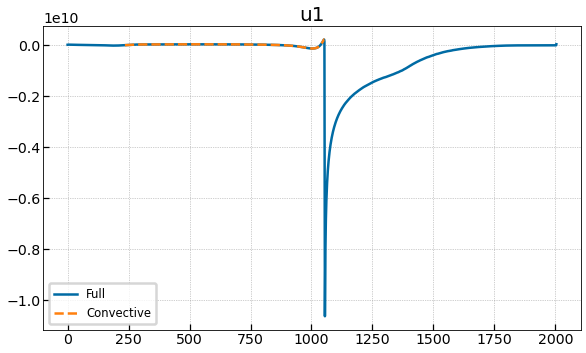

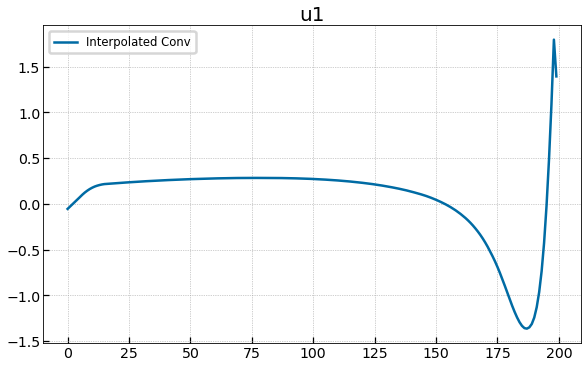

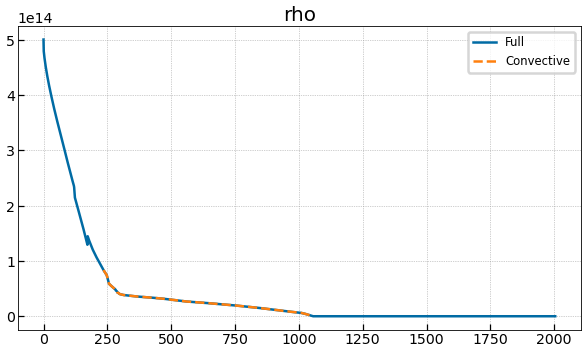

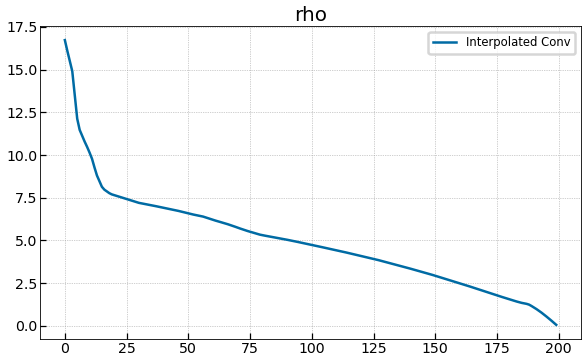

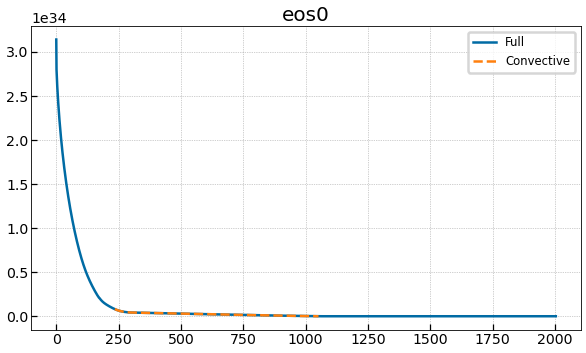

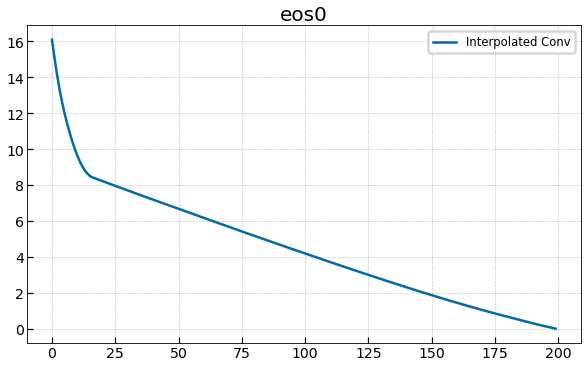

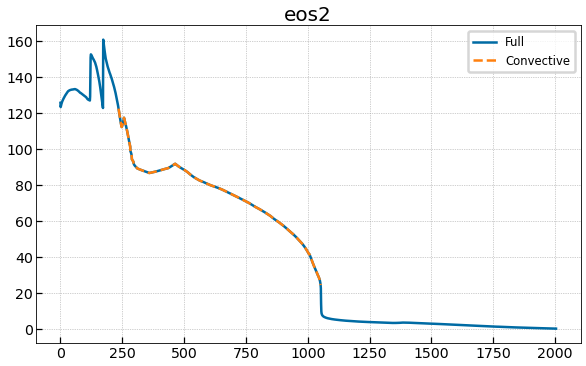

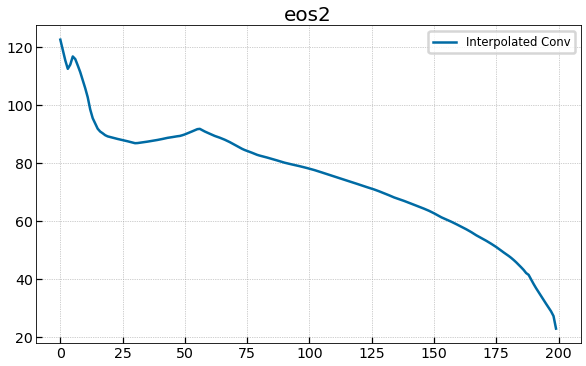

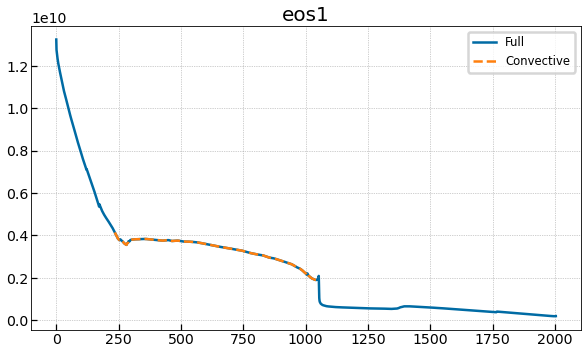

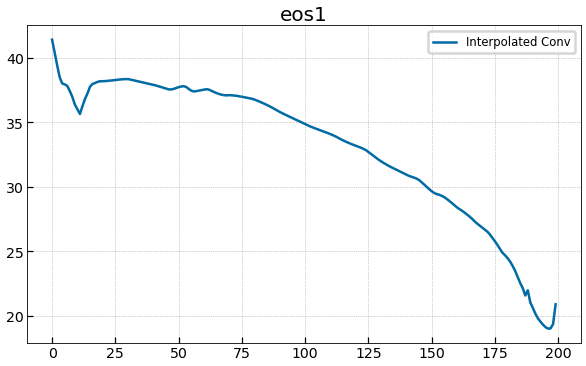

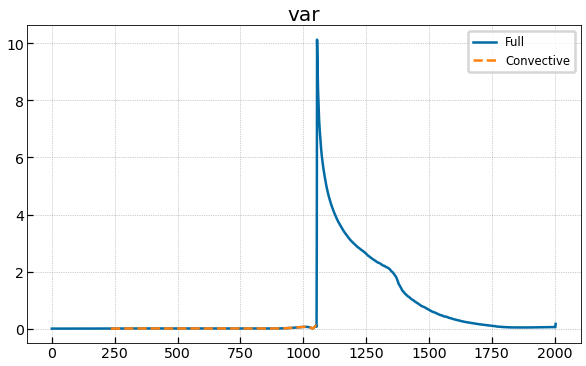

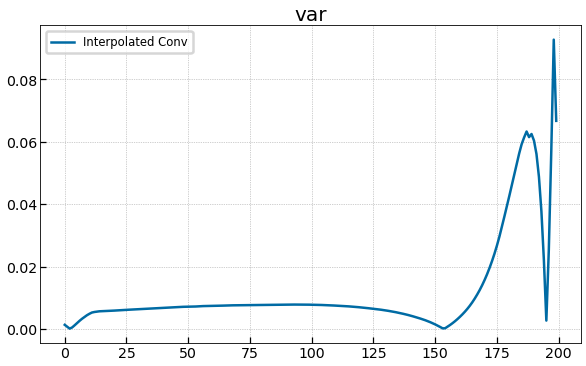

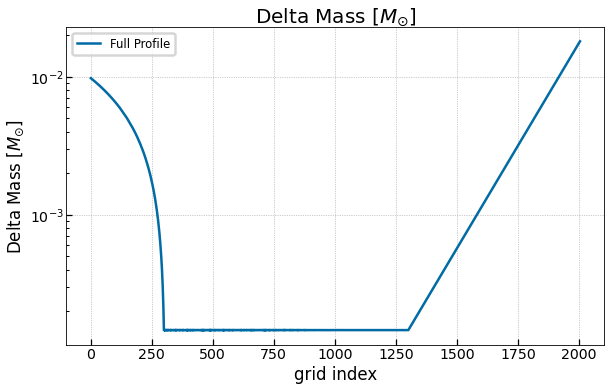

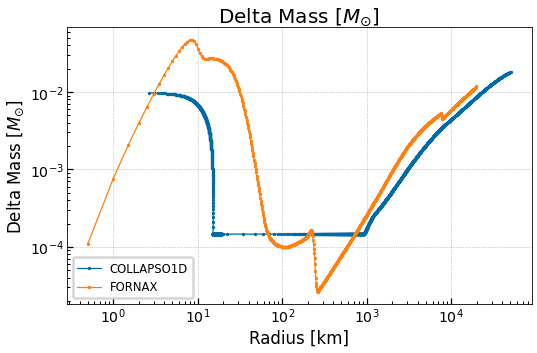

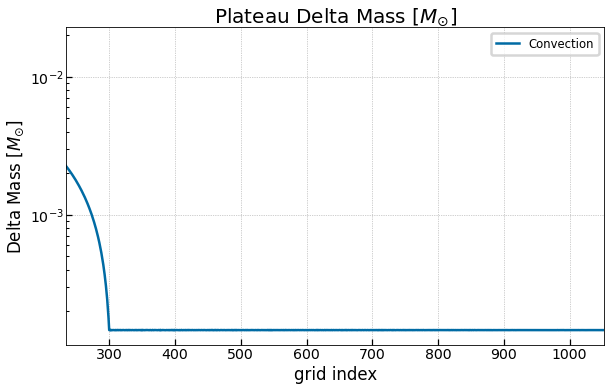

In [8]:
# Compare with a COLLAPSO1D output (preferrably of the same progenitor mass)

#base_path = '/home/pkarpov/COLLAPSO1D/project/1dmlmix/output/'
#base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g1.5k_c0.5k_p0.3k/'
base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g2k_c1k_p0.3k/'
base_file = 'DataOut_read'
dataset = 'DataOut'

i=700#490
    
file = f'{base_file}.{i}'
file1d = f'{base_path}/{file}'                        

with open(file1d, "r") as file:
    line = file.readline()        
    header_vals = file.readline()
    vals_strip = header_vals[:-1].split(' ')        
    time1d, bounce_time, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
    lumnue = rlumnue
    times = time1d    
    print(file.readline())
    
pns_ind = int(pns_ind)-1
shock_ind = int(shock_ind)-1
                
#print('Time %.2f ms'%(float(time1d)*1e3))

ps = np.loadtxt(file1d, skiprows=3)
ps = np.moveaxis(ps,0,1) 

# velocity, rho, P_gas, Vsound, T, entropy
#features_label = ['u1','rho','eos0','eos1','eos2','eos3']

#code_vals = np.array([ps[4],ps[3],ps[6],ps[vsound],ps[7],ps[entropy]])

ncell   = ps[0]
encm    = ps[1]
r       = ps[2]
rho     = ps[3]
v       = ps[4]
ye      = ps[5]
P       = ps[6]
T       = ps[7]*1e-9
vsound  = ps[8]
mach    = abs(v/vsound)
pturb   = np.zeros(v.shape)

Msol    = 1.989e33
dm      = np.zeros(v.shape)
dm[0]   = rho[0]*4/3*np.pi*r[0]**3/Msol

for i in range(1,len(v)):
    dm[i]   = 4/3*np.pi*rho[i]*(r[i]**3-r[i-1]**3)/Msol
    #np.around(encm[i]-encm[i-1], decimals=8)#
    
#for i, m in enumerate(dm): print(i,m)

code_vals = np.array([[v,rho,P,T,vsound,pturb,mach]])
print('codу vals', code_vals.shape)
#sys.exit()
#----------------------------------------------------------
y = np.array(None)
mlin_x, pns_i, shock_i = interp_var(code_vals, y, mlin_grid_size, fudge_pns=-700, fudge_shock=-3)

for i in range(mlin_x.shape[1]):
    try: 
        mlin_x[:,i] *= units[features_label[i]]
        print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')
    except: 
        mlin_x[:,i] *=1
        print(f'var min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')
    

index_full = range(len(v))
index_mlin = range(mlin_grid_size)

for i, val in enumerate(code_vals[0]):
    try: 
        title = features_label[i]
        if 'turb' in features_label[i]: continue

    except: title = 'var'
    ax = line_plot([[index_full,val],
                    [index_full[pns_i:shock_i], val[pns_i:shock_i]] 
                    ],
                    figsize   = (10,6),
                    label     = ['Full','Convective'],
                    linestyle = ['-', '--'],
                    plot_type = 'plot')
    ax.set_title(title)

    ax = line_plot([[index_mlin,mlin_x[0,i,:]]],
                    label = ['Interpolated Conv'],
                    figsize   = (10,6),)
    ax.set_title(title)
 
ax = line_plot([[range(1,len(dm)),dm[1:]]],
                label     = ['Full Profile'],
                figsize   = (10,6),
                plot_type = 'semilogy')
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel('grid index')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

# ax = line_plot([[r[1:]/udist,dm[1:]],
#                 [r_fornax[1:],dm_fornax[1:]]],
#                 label     = ['COLLAPSO1D', 'FORNAX'],
#                 figsize   = (10,6),
#                 plot_type = 'loglog')

fig = plt.figure(figsize=(10,6), dpi=60)
ax  = fig.add_subplot(111)
label  = ['COLLAPSO1D', 'FORNAX']
series = [[r[1:]/udist,dm[1:]],
          [r_fornax[1:],dm_fornax[1:]]]
for idx, data in enumerate(series):
    ax.loglog(data[0], data[1], linewidth=1.5, marker='.', label=label[idx])
plt.legend()
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel('Radius [km]')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

#ax = line_plot([[range(shock_i-pns_i),dm[pns_i:shock_i]]],
ax = line_plot([[range(1,len(dm)),dm[1:]]],
                label     = ['Convection'],
                figsize   = (10,6),
                plot_type = 'semilogy')
ax.set_title(r'Plateau Delta Mass [$M_{\odot}$]')
ax.set_xlabel('grid index')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')
ax.set_xlim(pns_i,shock_i)

 Cell  M_enclosed [M_sol]  Radius [cm]  Rho [g/cm^3]  Velocity [cm/s]  Ye  Pressure [g/cm/s^2]  Temperature [K]  Sound [cm/s]  Entropy [kb/baryon]

code vals (1, 7, 9983)
Convective region from/to:  0 313
u1 min: -4.945e+00, max: -3.625e-01
rho min: 3.218e-05, max: 5.705e-03
eos0 min: 1.236e-06, max: 7.295e-04
eos2 min: 6.473e+00, max: 1.055e+01
eos1 min: 6.890e+00, max: 1.301e+01
Pturb_s2 min: 0.000e+00, max: 0.000e+00
var min: 2.786e-02, max: 7.135e-01
max r 2032248000.0
Min dm at  300 3.056575786919416e-05 1.3446
Min dm at  301 3.048705189387296e-05 1.3446
Min dm at  302 3.054368671408812e-05 1.3446
Min dm at  303 3.057852424592303e-05 1.3447
Min dm at  304 3.0533051277195645e-05 1.3447
Min dm at  305 3.0579216553665516e-05 1.3447
Min dm at  306 3.0516075380297874e-05 1.3447
Min dm at  307 3.0567469636948546e-05 1.3448
Min dm at  308 3.053549544153464e-05 1.3448
Min dm at  309 3.0549686931868676e-05 1.3448
Min dm at  310 3.0559107090271e-05 1.3449
Min dm at  311 3.0506457508686452e-

Text(0, 0.5, 'Delta Mass [$M_{\\odot}$]')

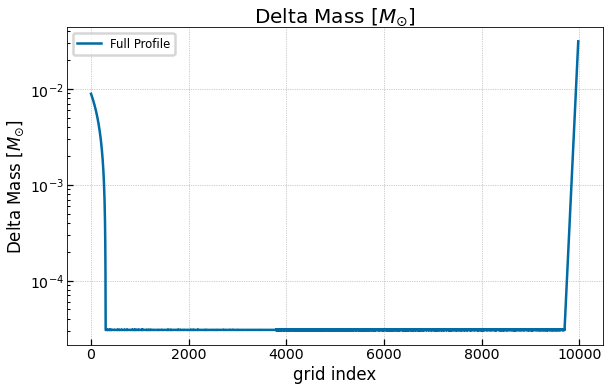

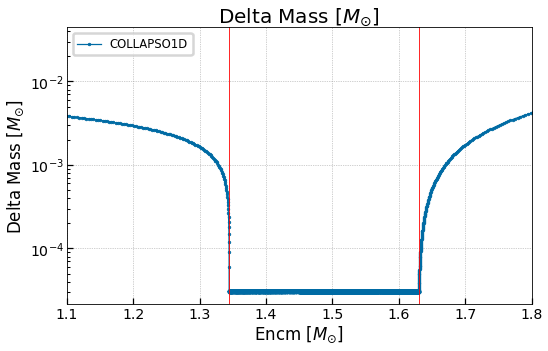

In [36]:
# Compare with a COLLAPSO1D output (preferrably of the same progenitor mass)

import numpy as np

#base_path = '/home/pkarpov/COLLAPSO1D/project/1dmlmix/output/'
#base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g1.5k_c0.5k_p0.3k/'
base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g10k_c9.4k_p0.3k/'
# base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s19.0_g4k_c3k_p0.3k/'
# base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s12.0_g6k_c5k_p0.3k/'
# base_path = '/home/pkarpov/scratch/1dccsn/sfho_s/encm_tuned/s18.0_g9k_c8.4k_p_0.3k/'
base_file = 'DataOut_read'
dataset = 'DataOut'

i=400#650#571#580
    
file = f'{base_file}.{i}'
file1d = f'{base_path}/{file}'                        

with open(file1d, "r") as file:
    line = file.readline()        
    header_vals = file.readline()
    vals_strip = header_vals[:-1].split(' ')        
    time1d, bounce_time, pns_ind, pns_x, shock_ind, shock_x, rlumnue = [float(x) for x in vals_strip if x!='']        
    lumnue = rlumnue
    times = time1d    
    print(file.readline())
    
pns_ind = int(pns_ind)-1
shock_ind = int(shock_ind)-1
                
#print('Time %.2f ms'%(float(time1d)*1e3))

ps = np.loadtxt(file1d, skiprows=3)
ps = np.moveaxis(ps,0,1) 

# velocity, rho, P_gas, Vsound, T, entropy
#features_label = ['u1','rho','eos0','eos1','eos2','eos3']

#code_vals = np.array([ps[4],ps[3],ps[6],ps[vsound],ps[7],ps[entropy]])

ncell   = ps[0]
encm    = ps[1]
r       = ps[2]
rho     = ps[3]
v       = -abs(ps[4])
ye      = ps[5]
P       = ps[6]
T       = ps[7]*1e-9
vsound  = ps[8]
mach    = abs(v/vsound)
pturb   = np.zeros(v.shape)

Msol    = 1.989e33
dm      = np.zeros(v.shape)
dm[0]   = rho[0]*4/3*np.pi*r[0]**3/Msol

for i in range(1,len(v)):
    dm[i]   = 4/3*np.pi*rho[i]*(r[i]**3-r[i-1]**3)/Msol
    #np.around(encm[i]-encm[i-1], decimals=8)#
    
#for i, m in enumerate(dm): print(i,m)

code_vals = np.array([[v,rho,P,T,vsound,pturb,mach]])
print('code vals', code_vals.shape)
#sys.exit()
#----------------------------------------------------------
y = np.array(None)
mlin_x, pns_i, shock_i = interp_var(code_vals, y, mlin_grid_size,fudge_shock=0)#, fudge_pns=-700, fudge_shock=-3)

for i in range(mlin_x.shape[1]):
    try: 
        mlin_x[:,i] *= units[features_label[i]]
        print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')
    except: 
        mlin_x[:,i] *=1
        print(f'var min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')
    

index_full = r/1e5#range(len(v))
index_mlin = range(mlin_grid_size)

# for i, val in enumerate(code_vals[0]):
#     try: 
#         title = features_label[i]
#         if 'turb' in features_label[i]: continue    
#     except: title = 'var'
    
#     if i==0: plot_type='semilogx'#'plot'
#     else: plot_type = 'loglog'
    
#     ax = line_plot([[index_full,val],
#                     [index_full[pns_i:shock_i], val[pns_i:shock_i]] 
#                     ],
#                     figsize   = (10,6),
#                     label     = ['Full','Convective'],
#                     linestyle = ['-', '--'],
#                     plot_type = plot_type)    
#     ax.set_title(title)
#     ax.set_xlim(0.5,3e4)

#     ax = line_plot([[index_mlin,mlin_x[0,i,:]]],
#                     label     = ['Interpolated Conv'],
#                     figsize   = (10,6),
#                     plot_type = plot_type)
#     ax.plot(index_mlin,mlin_x[0,i,:], linewidth=0, marker='.', label=label[idx])
#     ax.set_title(title)
 
ax = line_plot([[range(1,len(dm)),dm[1:]]],
                label     = ['Full Profile'],
                figsize   = (10,6),
                plot_type = 'semilogy')
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel('grid index')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

# ax = line_plot([[r[1:]/udist,dm[1:]],
#                 [r_fornax[1:],dm_fornax[1:]]],
#                 label     = ['COLLAPSO1D', 'FORNAX'],
#                 figsize   = (10,6),
#                 plot_type = 'loglog')

fig = plt.figure(figsize=(10,6), dpi=60)
ax  = fig.add_subplot(111)
label  = ['COLLAPSO1D', 'FORNAX']
series = [[r[1:]/udist,dm[1:]],
          [r_fornax[1:],dm_fornax[1:]]]

series = [[encm[1:],dm[1:]],
          ]#[r_fornax[1:],dm_fornax[1:]]]
for idx, data in enumerate(series):
    # ax.loglog(data[0], data[1], linewidth=1.5, marker='.', label=label[idx])
    ax.semilogy(data[0], data[1], linewidth=1.5, marker='.', label=label[idx])

print('max r', r[-1])
for i in range(len(encm)):
    if dm[i]<4e-5: print('Min dm at ', i, dm[i], encm[i])
ax.axvline(1.345, color='r',linewidth=1)
ax.axvline(1.63, color='r',linewidth=1)    
# ax.set_xlim(1.33,1.64)
ax.set_xlim(1.1,1.8)
plt.legend()
ax.set_title(r'Delta Mass [$M_{\odot}$]')
ax.set_xlabel(r'Encm [$M_{\odot}$]')
ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')

#ax = line_plot([[range(shock_i-pns_i),dm[pns_i:shock_i]]],
# ax = line_plot([[range(1,len(dm)),dm[1:]]],
#                 label     = ['Convection'],
#                 figsize   = (10,6),
#                 plot_type = 'semilogy')
# ax.set_title(r'Plateau Delta Mass [$M_{\odot}$]')
# ax.set_xlabel('grid index')
# ax.set_ylabel(r'Delta Mass [$M_{\odot}$]')
# ax.set_xlim(pns_i,shock_i)

1000.00, 1000.00
1046.08, 1055.56
1094.29, 1111.11
1144.71, 1166.67
1197.46, 1222.22
1252.65, 1277.78
1310.37, 1333.33
1370.76, 1388.89
1433.92, 1444.44
1500.00, 1500.00


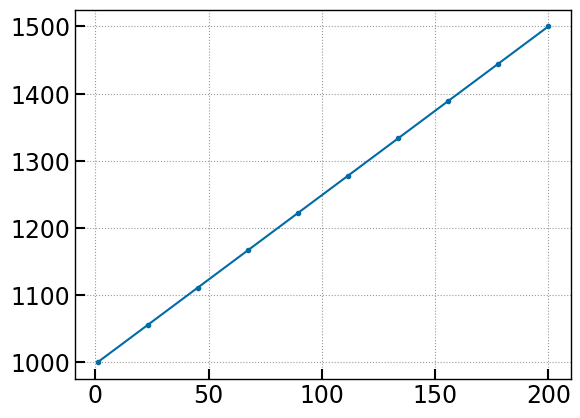

In [43]:
import numpy as np

x = np.linspace(1,200, 10)
y10 = np.logspace(np.log10(1000),np.log10(1500), 10, base=10)
y2 = np.logspace(np.log2(1000),np.log2(1500), 10, base=2)
ylin = np.linspace(1000,1500,10)
for i in range(10):
    print(f'{y10[i]:.2f}, {ylin[i]:.2f}')

plt.plot(x,y, marker='.', linewidth = 1.5)